In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

## Ch 14. Excercise 8

In fact, Luis already put his solution to github(https://github.com/luisandresilva/Kaggle/tree/master/Rain-II). He used Keras API and python 2. Here, we will reproduce his model for latest tf.keras API and python 3.

First, download data of "How Much Did It Rain? II" competition and put it on `datasets/rain2` folder. Read the `train.csv`

In [2]:
rain2 = pd.read_csv('datasets/rain2/train.csv')

Let's view some rows via `head()` method of pandas's `DataFrame`

In [3]:
rain2.head(n=30)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
5,1,55,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
6,2,1,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016000
7,2,6,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016000
8,2,11,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016000
9,2,16,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,...,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016000


There are 24 columns. First column `Id` is unique value representing a sequence. Last column `Expected` is target. We simply remove rows that `Ref` column is `NaN`. If `Ref` column is `NaN`, all other columns is `NaN` too.

In [4]:
train_df = rain2.dropna(subset=['Ref'])

Using `describe()` method, we get the statistics for dataset. The features excluding `Id` and `Expected` has different scale. But the order of magnitude is not significant.

In [5]:
train_df.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,6.349375e+06,6.349375e+06,6.349375e+06,6.349375e+06,5.269105e+06,6.156846e+06,6.349288e+06,6.349375e+06,5.550921e+06,6.207490e+06,...,4.600898e+06,4.069799e+06,3.577674e+06,4.095586e+06,4.600898e+06,3.494665e+06,2.978691e+06,3.511354e+06,4.062702e+06,6.349375e+06
mean,5.894813e+05,2.927051e+01,9.286182e+00,2.292666e+01,1.998385e+01,2.302103e+01,2.812518e+01,2.540071e+01,2.256900e+01,2.541082e+01,...,1.013113e+00,5.295568e-01,-6.975932e-01,3.815768e-01,2.057199e+00,3.230033e-02,-3.409001e+00,-3.781228e-01,4.038652e+00,1.714876e+01
std,3.406124e+05,1.715383e+01,4.068784e+00,1.035516e+01,9.195141e+00,9.882618e+00,1.028228e+01,1.044013e+01,9.547383e+00,1.003713e+01,...,4.179456e-02,1.476643e+00,1.017368e+00,9.260191e-01,1.617217e+00,3.699795e+00,2.719573e+00,2.087361e+00,3.902270e+00,2.025279e+02
min,2.000000e+00,0.000000e+00,0.000000e+00,-3.100000e+01,-3.200000e+01,-3.200000e+01,-2.850000e+01,-2.800000e+01,-3.050000e+01,-2.750000e+01,...,2.083333e-01,-7.875000e+00,-7.875000e+00,-7.875000e+00,-7.875000e+00,-9.604000e+01,-8.079000e+01,-7.168000e+01,-1.002000e+02,1.000000e-02
25%,2.923290e+05,1.400000e+01,6.000000e+00,1.600000e+01,1.450000e+01,1.650000e+01,2.150000e+01,1.850000e+01,1.650000e+01,1.850000e+01,...,9.983333e-01,-1.875000e-01,-1.062500e+00,0.000000e+00,1.062500e+00,-1.410004e+00,-4.540008e+00,-7.100067e-01,2.059998e+00,5.080003e-01
50%,5.906240e+05,2.900000e+01,1.000000e+01,2.250000e+01,2.000000e+01,2.300000e+01,2.750000e+01,2.500000e+01,2.250000e+01,2.500000e+01,...,1.005000e+00,3.750000e-01,-6.250000e-01,3.125000e-01,1.687500e+00,0.000000e+00,-2.820007e+00,0.000000e+00,3.509994e+00,1.425001e+00
75%,8.883170e+05,4.400000e+01,1.200000e+01,2.950000e+01,2.600000e+01,2.950000e+01,3.500000e+01,3.200000e+01,2.900000e+01,3.200000e+01,...,1.051667e+00,1.062500e+00,-1.875000e-01,6.875000e-01,2.562500e+00,1.409988e+00,-1.740006e+00,3.499908e-01,5.629990e+00,4.064002e+00
max,1.180945e+06,5.900000e+01,2.100000e+01,7.100000e+01,6.250000e+01,6.900000e+01,7.250000e+01,9.250000e+01,6.600000e+01,7.100000e+01,...,1.051667e+00,7.937500e+00,7.937500e+00,7.937500e+00,7.937500e+00,1.797500e+02,3.169998e+00,1.280000e+01,1.446000e+02,3.301773e+04


We removed the rows that `Ref` column is `NaN`. But there are still `NaN` values. Let's check How many `NaN` are in the `train_df`.

In [6]:
train_df.isna().sum()

Id                             0
minutes_past                   0
radardist_km                   0
Ref                            0
Ref_5x5_10th             1080270
Ref_5x5_50th              192529
Ref_5x5_90th                  87
RefComposite                   0
RefComposite_5x5_10th     798454
RefComposite_5x5_50th     141885
RefComposite_5x5_90th         67
RhoHV                    2279576
RhoHV_5x5_10th           2771701
RhoHV_5x5_50th           2253789
RhoHV_5x5_90th           1748477
Zdr                      2279576
Zdr_5x5_10th             2771701
Zdr_5x5_50th             2253789
Zdr_5x5_90th             1748477
Kdp                      2854710
Kdp_5x5_10th             3370684
Kdp_5x5_50th             2838021
Kdp_5x5_90th             2286673
Expected                       0
dtype: int64

Ok. For simplicity, just fill `NaN` cell with 0.

In [7]:
train_df = train_df.fillna(0)
train_df.isna().sum()

Id                       0
minutes_past             0
radardist_km             0
Ref                      0
Ref_5x5_10th             0
Ref_5x5_50th             0
Ref_5x5_90th             0
RefComposite             0
RefComposite_5x5_10th    0
RefComposite_5x5_50th    0
RefComposite_5x5_90th    0
RhoHV                    0
RhoHV_5x5_10th           0
RhoHV_5x5_50th           0
RhoHV_5x5_90th           0
Zdr                      0
Zdr_5x5_10th             0
Zdr_5x5_50th             0
Zdr_5x5_90th             0
Kdp                      0
Kdp_5x5_10th             0
Kdp_5x5_50th             0
Kdp_5x5_90th             0
Expected                 0
dtype: int64

We can group by `Id` column via `groupby` method. This is the sequence we feed into the model.

In [8]:
train_seq = train_df.groupby(['Id'])

Now, let's check the number of unique `Id` and maximum length of sequence. `size()` method return the length of each group. It's pandas's `Series` object that has `count()` and `max()` method.

In [9]:
train_seq_size = train_seq.size()
train_seq_size.count(), train_seq_size.max()

(731556, 19)

Now, we know number of sequence and max length of each sequence. So we can make numpy array `X` and `y`. `X` has 731,556 sequences. Each sequence has up to 19 rows. Each row has 22 features. `y` has just one column for `Expected`.

In [10]:
X = np.zeros((731556, 19, 22))
y = np.zeros((731556, 1))

Luis applied some preprocessing and feature extraction. Here, we just try to apply raw dataset to LSTM without any preprocessing.

In [11]:
i = 0
for name, group in train_seq:
    # d.shape is (seq_length, 24)
    d = group.values
    # column 1~22 are features.
    # column 0 is Id and column 23 is target.
    # save 1~22 features to 0~21 index of dataset up to d.shape[0].
    X[i, :d.shape[0], 0:22] = d[:, 1:23]
    y[i, 0] = d[0, 23]
    i += 1;
print(i)

731556


We split dataset to train set and test set. In fact test set is validation set for this task. Total dataset size is 731,556. Test set is sufficient 10% of the data.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Calculate `steps_per_epoch` and `validation_steps` for `fit_generator()` method. We set `batch_size` is 1024.

In [14]:
batch_size = 1024
steps_per_epoch = np.ceil(X_train.shape[0] / batch_size)
validation_steps = np.ceil(X_test.shape[0] / batch_size)
steps_per_epoch, validation_steps

(643.0, 72.0)

This model has three layers. `LSTM` layer has 50 units. It is just Luis choice. Final `Dense` layer has 1 unit without activation for `Expected` target. All other parameters of `LSTM` and `Dense` layer use default value. Loss is `'mae'` for regression task. We choose `'adam'` optimizer with default values.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(50, input_shape=(None, 22), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

Model training is simple. We just put the two generators and steps for epoch and validation. Let's try 150 epochs.

In [20]:
callbacks_list = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='14_ex_8.h5', monitor='val_loss', save_best_only=True)]
history = model.fit(X_train, y_train,
                    epochs=150, batch_size=512,
                    validation_split=0.25,
                    callbacks=callbacks_list)

Train on 493800 samples, validate on 164600 samples
Epoch 1/150
493800/493800 [==============================] - 42s 85us/step - loss: 23.2963 - val_loss: 23.1770
Epoch 2/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.2118 - val_loss: 23.1109
Epoch 3/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.1849 - val_loss: 23.1646
Epoch 4/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.1757 - val_loss: 23.1062
Epoch 5/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.1713 - val_loss: 23.1158
Epoch 6/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.1618 - val_loss: 23.0918
Epoch 7/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.1564 - val_loss: 23.0897
Epoch 8/150
493800/493800 [==============================] - 40s 81us/step - loss: 23.1573 - val_loss: 23.0747
Epoch 9/150
493800/493800 [==============================] -

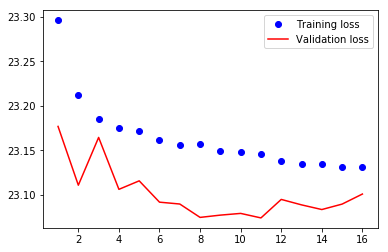

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

In [23]:
model.load_weights('14_ex_8.h5')

Now we can make prediction for test data. Read the test.csv file and fill `NaN` with 0.

In [24]:
rain2_test = pd.read_csv('datasets/rain2/test.csv')
test_df = rain2_test.fillna(0)

Test data has 23 columns not 24 columns. It doesn't have `Expected` column.

In [25]:
test_df.head()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
0,1,1,8.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,8.0,10.0,0.0,10.0,18.0,11.5,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,8,8.0,0.0,0.0,7.0,14.5,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,12,8.0,14.0,0.0,9.0,16.0,14.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,15,8.0,10.5,0.0,9.0,15.5,13.5,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ok. Let's check the number of sequences and maximum length just like above.

In [26]:
test_seq = test_df.groupby(['Id'])
test_seq_size = test_seq.size()
test_seq_size.count(), test_seq_size.max()

(717625, 19)

Create `X_text` numpy array. Its size is (717625, 19, 22).

In [27]:
X_test = np.zeros((717625, 19, 22))

Just like train data, copy `test_seq` to `X_test`.

In [28]:
i = 0
for name, group in test_seq:
    # d.shape is (seq_length, 23)
    d = group.values
    # column 1~22 are features.
    # save 1~22 features to 0~21 index of dataset up to d.shape[0].
    X_test[i, :d.shape[0], 0:22] = d[:, 1:23]
    i += 1;
print(i)

717625


Now we can feed `X_test` to our model and get the predictions!

In [29]:
pred = model.predict(X_test)

Making submission file, we stack `pred` array and its index horizontally. Using `numpy.savetxt`, we can make csv file with format("int, float") and title("Id,Expected").

In [30]:
pred_with_index = np.hstack((np.arange(1, pred.shape[0]+1).reshape(-1,1), pred))
np.savetxt("datasets/rain2/test_prediction.csv", pred_with_index, "%d,%f", 
           delimiter=",", header="Id,Expected", comments="")

In [31]:
!head "datasets/rain2/test_prediction.csv"

Id,Expected
1,0.473683
2,0.250590
3,2.757972
4,5.341240
5,0.266192
6,0.785535
7,2.634934
8,0.696415
9,0.169597


If you submit this file to Kaggle competition(https://www.kaggle.com/c/how-much-did-it-rain-ii/submit), you will get about 23.78 score. It may be ranked before 100. Cool!

You can stack another `LSTM` layer and change weight initializer or optimizer. If you want to search more parameters, it's better to use `keras.wrappers.scikit_learn.KerasClassifier` with scikit-learn's `GridSearchCV`.